### Viewing the data

In [1]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
from datetime import datetime

In [2]:
def read_csvs(country_list=None):
    """
    Reads all csv files in folder path given and stores them in a single dataframe df 
    Parameters: list of countries to read their csv
    ----------
    Returns
    -------
    pandas.DataFrame
        Dataframe where rows are individual data and columns for indicative
        information on the data like datetime, month, week, country etc
    """

    df = pd.DataFrame()
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

    # For every csv file in folder 
    for csv in pathlib.Path('../Temp Load Data/').glob('*.csv'):
        if(country_list is None or csv.stem in country_list):            
            print("Loading dataset: "+csv.stem)
            temp_df = pd.read_csv(csv,
                                  parse_dates=['Date'],
                                  dayfirst=True,
                                  date_parser=dateparse)
            temp_df['country'] = csv.stem #set cokumn with the name of the dataset this datum came from
            df = pd.concat([df,temp_df]) 
    print('Data loading complete!')
    # sort values based on Start column (Datetime)
    df = df[df['year'] != 2022] # remove rows of year 2022 since its an incomplete year (not currently ended)
    if(country_list is None):
        df.sort_values(by=['Date'], ascending=True, inplace=True)
    df['Unnamed: 0'] = range(1, len(df) + 1)     # Reset "Unnamed: 0" based on concated df 
    return df

country_list = ['Austria']
df = read_csvs(country_list)
df_backup = df.copy()

Loading dataset: Austria
Data loading complete!


### Preparing the data in general

#### Categorical variables: one-hot encoding

A column like weekday actually contains 7 possible values, 0 through 6, each of which represents a different day of the week. Instead of representing this data as 1 feature with 7 values, it works better if we represent if as 7 binary features. This process is known as one-hot encoding and is nicely explained by Chris Albon [here](https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_nominal_categorical_features/). 
Note that 'holiday' is effectively already one-hot encoded as it either has a value 0 for 'not a holiday' or 1 for 'is a holiday'.

#### Continuous variables: scaling
It is common practice to scale the continuous variables, i.e. to standardize them on a zero mean with a standard deviation of 1. We do this even for 'Load' which is our target variable, and therefore we need to be able to get back again to get an actual number of bikes predicted so we'll save away the various means and standard deviations for converting back later.

In [3]:
# Standardize 'Load' feature by using its mean and std
mean, std = df['Load'].mean(), df['Load'].std()
df[['Load']] = (df[['Load']] - mean)/std

#### Data we won't use

### Preparing the data for training

#### Train / test / validation split
This is a timeseries problem, so it would be typical to train on the earlier data, and test / validate on the later data.

In [4]:
def train_test_valid_split(df):
    """
    we choose to split data with validation/test data to be at the end of time series
    Since it's a time series, it is intuitive to predict future values, rather than values in between
    validation/test should hold at least an entire year, since:
        - most seasonality exists between years
        - there are fluctuation inside year (e.g heatwaves at summer)
    Parameters:
        pandas.dataframe containing dataframe to split
    Returns:
        pandas.dataframe containing train/test/valiation data
        pandas.dataframe containing valiation data
        pandas.dataframe containing test data
    """
    # train_data: data from year [2015,2019]
    # validation_data: data from year 2020
    # test_data: data from year 2021
    # drop all columns except 'Load' (use 'backup_df' to restore them)
    train_data = df[~df['year'].isin(['2020','2021'])][['Load']]
    test_data = df[df['year'] == 2021][['Load']]
    validation_data = df[df['year'] == 2020][['Load']]

    print("dataframe shape: {}".format(df.shape))
    print("train shape: {}".format(train_data.shape))
    print("test shape: {}".format(test_data.shape))
    print("validation shape: {}".format(validation_data.shape))
    
    return train_data, test_data, validation_data 

# df = df_backup.copy() # for debugging
# split data in train/test/validation
train_data, test_data, validation_data = train_test_valid_split(df)
validation_data.head()

dataframe shape: (58993, 19)
train shape: (58993, 1)
test shape: (8760, 1)
validation shape: (8784, 1)


,Load
41449,-0.559674
41450,-0.764123
41451,-0.898725
41452,-1.009317
41453,-1.239959


In [5]:
def feauture_target_split(df, lookback_window, forecast_horizon):
    """
    This function gets a column of a dataframe and splits it to input and target
    
    **lookback_window**
    In a for-loop of 'lookback_window' max iterations, starting from 0 
    At N-th iteration (iter): 
        1. create a shifted version of 'Load' column by N rows (vertically) and 
        2. stores it in a column* (feauture_'N')

    Same pseudo-code for 'forecast_horizon' loop
    
    *At first iterations of both loops, the new columns (feauture/target) are going to be firstly created
    but for each iteration, the same columns are going to be used
    
    We store each new column created in a dictionary which, at the end, convert it to dataframe
    The reason behind this choice is that if it was initially a dataframe, for large amount of loops,
    fast insertion of new columns would cause a performance issue (slower) even though the end result
    would propably not be altered
    
    Parameters: 
        df: pandas.dataframe containing column to parse
        lookback_window: lookback_window - # feature columns - # inputs in model
        forecast_horizon: forecast_horizon - # target columns - # outputs in model
    ----------
    Returns
        'subset'_X: pandas.dataframe containing feautures of df after preprocess for model
        'subset'_Y: pandas.dataframe containing targets of df after preprocess for model
    -------
    """

    print(f"lookback_window: {lookback_window}")
    print(f"forecast_horizon: {forecast_horizon}")

    # Reset "Unnamed: 0" based on concated df 
    df['Unnamed: 0'] = range(1, len(df) + 1)

    df_copy = df.copy()    

    df_new = {}
        
    for inc in range(0,int(lookback_window)):
        df_new['feauture_' + str(inc)] = df_copy['Load'].shift(-inc)

    # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
    df_copy['Load'] = df_copy['Load'].shift(-int(lookback_window))
                    
    for inc in range(0,int(forecast_horizon)):
        df_new['target_' + str(inc)] = df_copy['Load'].shift(-inc)    
    
    df_new = pd.DataFrame(df_new, index=df_copy.index)
    df_new = df_new.dropna().reset_index(drop=True)    
                        
    # store new dataset to csv (if needed) 
    df_new.to_csv("preprocess_for_model.csv")
    print("Done")
    
    return df_new.iloc[:,:lookback_window] , df_new.iloc[:,-forecast_horizon:]
    
    
lookback_window = 168 # 7 days (* 24 hours)
forecast_horizon = 36

# 'subset'_X: dataset containing features of subset (train/test/validation) dataframe
# 'subset'_Y: dataset containing targets of subset (train/test/validation) dataframe
train_X, train_Y = feauture_target_split(train_data, lookback_window, forecast_horizon)  
validation_X, validation_Y = feauture_target_split(validation_data, lookback_window, forecast_horizon)  
test_X, test_Y = feauture_target_split(test_data, lookback_window, forecast_horizon)  

# train_X, train_Y

lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done


### Defining the model and hyperparameters
Before proceeding with this section, I'd recommend taking a look at the PyTorch Lightning [INTRODUCTION GUIDE](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html) which describes how each section of the LightningModule template contributes and fits together. You'll recognize the same components that you're used to in PyTorch, but they are organized into functions with specific naming conventions that need to be adhered to.

In [6]:
# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
from pytorch_lightning.callbacks import EarlyStopping

In [138]:
class Regression(pl.LightningModule):
    """
    Regression  Techniques are used when the output is real-valued based on continuous variables. 
                For example, any time series data. This technique involves fitting a line
    Feature: Features are individual independent variables that act as the input in your system. 
             Prediction models use features to make predictions. 
             New features can also be obtained from old features using a method known as ‘feature engineering’. 
             More simply, you can consider one column of your data set to be one feature. 
             Sometimes these are also called attributes. T
             The number of features are called dimensions
    Target: The target is whatever the output of the input variables. 
            In our case, it is the output value range of load. 
            If the training set is considered then the target is the training output values that will be considered.
    Labels: Label: Labels are the final output. You can also consider the output classes to be the labels. 
            When data scientists speak of labeled data, they mean groups of samples that have been tagged to one or more labels.

    ### The Model ### 
    Initialize the layers
    Here we have:
        one input layer (size 'lookback_window'), 
        one output layer (size 36 as we are predicting next 36 hours)
        hidden layers define by 'params' argument of init
    """
    def __init__(self,params):
        super(Regression, self).__init__()
        self.l_rate = params['l_rate']
        self.batch_size = params['batch_size']
        self.l_window = params['l_window']
        self.f_horizon = params['f_horizon']
        self.loss = nn.MSELoss(reduction = 'mean')
        self.optimizer_name = params['optimizer_name']
        self.dropout = params['dropout']
        self.output_dims = params['output_dims']
#         self.activation = params['activation']
        
        layers = [] #list of layer to add at nn

        input_dim = self.l_window #input dim set to lookback_window
        output_dim = self.f_horizon #output dim set to f_horizon
        
        """
        Each loop is the setup of a new layer
        At each iteration:
            1. add previous layer to the next (with parameters gotten from output_dims)
                    at first iteration previous layer is input layer
            2. add activation function
            3. add dropout 
            4. set current_layer as next layer
        connect last layer with cur_layer
        """
        for cur_layer in self.output_dims: 
            layers.append(nn.Linear(input_dim, cur_layer))
            layers.append(nn.ReLU())
#             layers.append(getattr(nn, self.activation)()) # nn.activation_function (as suggested by Optuna)
            layers.append(nn.Dropout(self.dropout))
            input_dim = cur_layer #connect cur_layer with previous layer (at first iter, input layer)
        
        #connect last layer (stored at input_din) with target layer (output_dim)            
        layers.append(nn.Linear(input_dim, output_dim)) 
        self.layers = nn.Sequential(*layers) #list of nn layers

    # Perform the forward pass
    def forward(self, x):
        return self.layers(x)

### The Data Loaders ###     
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        feature = torch.tensor(train_X.values).float() #feauture tensor train_X
        target = torch.tensor(train_Y.values).float() #target tensor train_Y
        train_dataset = TensorDataset(feature, target)  # dataset bassed on feature/target
        train_loader = DataLoader(dataset = train_dataset,
                                  batch_size = self.batch_size)
        return train_loader
            
    def test_dataloader(self):
        feature = torch.tensor(test_X.values).float()
        target = torch.tensor(test_Y.values).float()
        test_dataset = TensorDataset(feature, target)
        test_loader = DataLoader(dataset = test_dataset,
                                 batch_size = self.batch_size)
        return test_loader

    def val_dataloader(self):
        feature = torch.tensor(validation_X.values).float()
        target = torch.tensor(validation_Y.values).float()
        validation_dataset = TensorDataset(feature, target)
        validation_loader = DataLoader(dataset = validation_dataset,
                                       batch_size = self.batch_size)
        return validation_loader

### The Optimizer ### 
    # Define optimizer function: here we are using ADAM
    def configure_optimizers(self):
        return getattr(optim, self.optimizer_name)(self.parameters(), lr=self.l_rate)

### Training ### 
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ###  
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log("val_loss", loss)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        min_loss = torch.stack([x['val_loss'] for x in outputs]).min()
        tensorboard_logs = {'val_loss': avg_loss}
        print('Average Epoch Validation loss: '+str(avg_loss.item()))
#         print('Minimum Epoch Validation loss: '+str(min_loss.item()))
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        correct = torch.sum(logits == y.data)
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [74]:
out = [ 2**j for j in range(1,8) ]
out

[2, 4, 8, 16, 32, 64, 128]

In [62]:
[str(x / 10) for x in range(0, 11)]

['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

In [139]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback

"""
This function is use by the Optuna library: An open source hyperparameter optimization framework
to automate hyperparameter search
In Optuna, there are two major terminologies, namely: 
1) Study: The whole optimization process is based on an objective function 
   i.e the study needs a function which it can optimize. 
2) Trial: A single execution of the optimization function is called a trial. 
Thus the study is a collection of trials

Optuna is a black-box optimizer, which means it needs an objective function, 
which returns a numerical value to evaluate the performance of the hyperparameters, 
and decide where to sample in upcoming trials

In Optuna:
    We create a "study", which corresponds to an optimization task (maximize/minimize the objective function)
    We then try to optimise (maximise/minimize) that objective 
        Since our objective functions returns (and therefore is based on) validation loss, we want
        to minimize that value rather than maximize
    Each "execution" of the objective function is basically a "trial"
        trial (in context): one training of model for specific set of suggestive parameters (check params)
    
"""

def objective(trial):
    # We optimize the number of layers, hidden units in each layer and dropouts.
    possible_batch_sizes = [ 2**j for j in range(6,8)] # list with all powers of in range [1,128] [64,128]
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout_rate = [x / 10 for x in range(0, 11)] # list of floats from 0 to 1.0 with step 0.1
#     max_epochs = trial.suggest_int('max_epochs', 1, 30) # ~~~~~~~~~~~ Try to use it!!!!!!
    max_epochs = 10
    
#   output_dims: list of layer_number and number of neurons in that layer
#                therefore 'n_layers' is propably redundant in dict but I like it there
    params = {
        'l_window' : lookback_window,
        'f_horizon': forecast_horizon,
        'n_layers' : trial.suggest_int("n_layers", 1, 3),
#         'dropout'  :   trial.suggest_categorical("dropout", dropout_rate),
        'dropout'  :   trial.suggest_float("dropout", 0.2, 0.5), 
        'output_dims': [trial.suggest_int("n_units_l{}".format(i), 40, 90, log=True) for i in range(n_layers)],
        'l_rate' :     trial.suggest_loguniform('l_rate', 1e-5, 1e-1),
#         'activation' : trial.suggest_categorical("activation", ["ReLU", "SiLU"]), #SiLU (Swish) performs good
        'optimizer_name' : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
        'batch_size' : trial.suggest_categorical('batch_size', possible_batch_sizes)
    }
    
    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    trainer = Trainer(max_epochs=max_epochs, auto_scale_batch_size=None, logger=True,
                      gpus=0 if torch.cuda.is_available() else None,
                      callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
                      deterministic=True)

    pl.seed_everything(42, workers=True)    
    model = Regression(params) # double asterisk (dictionary unpacking)
    trainer.logger.log_hyperparams(params)
    trainer.fit(model)
    return trainer.callback_metrics["val_loss"].item()

In [140]:
#  Example taken from Optuna github page:
# https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_lightning_simple.py

# Theory:
# https://coderzcolumn.com/tutorials/machine-learning/simple-guide-to-optuna-for-hyperparameters-optimization-tuning
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

def print_optuna_report(study):
    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~ Optuna Report ~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
# The pruners module defines a BasePruner class characterized by an abstract prune() method, which, 
# for a given trial and its associated study, returns a boolean value 
# representing whether the trial should be pruned (aborted)

# optuna.pruners.MedianPruner() 
# optuna.pruners.NopPruner() (no pruning)
# Hyperband performs best with default sampler for non-deep learning tasks
pruner: optuna.pruners.BasePruner = optuna.pruners.MedianPruner() # experimentally better performance
    
# default sampler: TPMESampler    
study = optuna.create_study(direction="minimize", pruner=pruner)
"""
timeout (Union[None, float]) – Stop study after the given number of second(s). 
None represents no limit in terms of elapsed time. 
The study continues to create trials until: the number of trials reaches n_trials, 
                                            timeout period elapses, stop() is called or, 
                                            a termination signal such as SIGTERM or Ctrl+C is received.
"""
study.optimize(objective, 
               timeout=800,
               n_trials=100)
print_optuna_report(study)

[I 2022-10-04 19:21:32,802] A new study created in memory with name: no-name-8e0fc46d-d83b-457b-bd3d-5aa73673b0c0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 18.9 K
--------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.075     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.5774915218353271


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.29503098130226135


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2645207643508911


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2555783987045288


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.27074700593948364


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.26697012782096863


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2601301968097687


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.26913511753082275


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.27340376377105713


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.25015830993652344


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:22:24,097] Trial 0 finished with value: 0.25507017970085144 and parameters: {'n_layers': 3, 'dropout': 0.21168099655859085, 'n_units_l0': 70, 'n_units_l1': 49, 'n_units_l2': 41, 'l_rate': 0.0024294217405958886, 'optimizer_name': 'Adam', 'batch_size': 128}. Best is trial 0 with value: 0.25507017970085144.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.25292935967445374



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 12.6 K
--------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.050     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.569608449935913


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0033063888549805


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0192209482192993


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0309308767318726


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.8500486612319946


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0491660833358765


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0615097284317017


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0023574829101562


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.9930548071861267


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.9265327453613281


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:23:09,529] Trial 1 finished with value: 0.950701117515564 and parameters: {'n_layers': 2, 'dropout': 0.3398049341081879, 'n_units_l0': 50, 'n_units_l1': 47, 'l_rate': 0.023588764765868925, 'optimizer_name': 'RMSprop', 'batch_size': 128}. Best is trial 0 with value: 0.25507017970085144.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.9418206810951233



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 16.4 K
--------------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2181951999664307


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.37939631938934326


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.29778146743774414


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.26537078619003296


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2558225393295288


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.24116049706935883


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2338094860315323


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.23065915703773499


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.23029722273349762


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.22444093227386475


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:24:44,144] Trial 2 finished with value: 0.22220635414123535 and parameters: {'n_layers': 3, 'dropout': 0.4692538343447542, 'n_units_l0': 43, 'n_units_l1': 46, 'n_units_l2': 85, 'l_rate': 0.00014267585412906377, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 0.22220635414123535.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.22114811837673187



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 16.5 K
--------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.572805643081665


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2930077016353607


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2448802888393402


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.25465500354766846


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.23493459820747375


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2523815631866455


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.24836568534374237


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2560722827911377


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.24088077247142792


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.24273283779621124


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:25:38,793] Trial 3 finished with value: 0.25528639554977417 and parameters: {'n_layers': 2, 'dropout': 0.39359752430260786, 'n_units_l0': 52, 'n_units_l1': 86, 'l_rate': 0.0019189242186275388, 'optimizer_name': 'Adam', 'batch_size': 128}. Best is trial 2 with value: 0.22220635414123535.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.2525698244571686



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.1994470357894897


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2194747030735016


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.16880109906196594


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1467849612236023


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.134883314371109


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12696658074855804


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12050608545541763


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.11541043967008591


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.112459197640419


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.11087106913328171


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:07,599] Trial 4 finished with value: 0.1103697195649147 and parameters: {'n_layers': 2, 'dropout': 0.2757923465440354, 'n_units_l0': 80, 'n_units_l1': 68, 'l_rate': 9.01088594845764e-05, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 4 with value: 0.1103697195649147.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 17.9 K
--------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.071     Total estimated model params size (MB)


Average Epoch Validation loss: 0.10981675237417221


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:07,764] Trial 5 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 20.3 K
--------------------------------------
20.3 K    Trainable params
0         Non-trainable params
20.3 K    Total params
0.081     Total estimated model params size (MB)


Average Epoch Validation loss: 1.574038028717041


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:07,949] Trial 6 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 15.1 K
--------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Average Epoch Validation loss: 1.5701472759246826


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.5578328371047974


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.9801471829414368


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:17,705] Trial 7 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 12.5 K
--------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Average Epoch Validation loss: 0.7775734066963196


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:17,902] Trial 8 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 24.8 K
--------------------------------------
24.8 K    Trainable params
0         Non-trainable params
24.8 K    Total params
0.099     Total estimated model params size (MB)


Average Epoch Validation loss: 1.625049352645874


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.5104997158050537


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.5162157416343689


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:28,061] Trial 9 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 18.1 K
--------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params
0.072     Total estimated model params size (MB)


Average Epoch Validation loss: 0.2882198989391327


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2730580568313599


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.7655835151672363


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:27:43,942] Trial 10 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 19.0 K
--------------------------------------
19.0 K    Trainable params
0         Non-trainable params
19.0 K    Total params
0.076     Total estimated model params size (MB)


Average Epoch Validation loss: 0.5270835161209106


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.206932544708252


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.40644097328186035


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:28:02,122] Trial 11 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 8.2 K 
--------------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Average Epoch Validation loss: 0.30414873361587524


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.281123399734497


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.19900895655155182


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.15535546839237213


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.13984835147857666


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.13542440533638


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12995634973049164


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12625326216220856


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1259477436542511


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1235327273607254


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12396374344825745


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12147606909275055


[I 2022-10-04 19:29:22,849] Trial 12 finished with value: 0.1220155581831932 and parameters: {'n_layers': 1, 'dropout': 0.44035846158335623, 'n_units_l0': 40, 'l_rate': 0.00022388985278939207, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 4 with value: 0.1103697195649147.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 13.2 K
--------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Sanity Checking: 0it [00:03, ?it/s]

Average Epoch Validation loss: 1.225738763809204


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1675233393907547


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1552286595106125


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.14253568649291992


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.15109169483184814


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.14169183373451233


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1439289152622223


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.13923417031764984


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.14269812405109406


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.14023913443088531


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:30:45,550] Trial 13 finished with value: 0.13697345554828644 and parameters: {'n_layers': 1, 'dropout': 0.4197235593156397, 'n_units_l0': 64, 'l_rate': 0.0003180317691631895, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 4 with value: 0.1103697195649147.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.13625015318393707



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 9.1 K 
--------------------------------------
9.1 K     Trainable params
0         Non-trainable params
9.1 K     Total params
0.036     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.207376480102539


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.0875709056854248


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:31:00,778] Trial 14 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 9.9 K 
--------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)


Average Epoch Validation loss: 1.0810601711273193


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2203714847564697


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.137055441737175


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.11778391897678375


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1091068759560585


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.11088034510612488


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10416914522647858


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10496868938207626


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.103696808218956


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10318239778280258


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10109791904687881


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:32:23,970] Trial 15 finished with value: 0.10443975776433945 and parameters: {'n_layers': 1, 'dropout': 0.28481039483127707, 'n_units_l0': 48, 'l_rate': 0.0004047555674929256, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 15 with value: 0.10443975776433945.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.10395269840955734



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 16.1 K
--------------------------------------
16.1 K    Trainable params
0         Non-trainable params
16.1 K    Total params
0.064     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2052916288375854


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.27158209681510925


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:32:42,570] Trial 16 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 13.6 K
--------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)


Average Epoch Validation loss: 0.2507384121417999


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:32:42,814] Trial 17 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 22.4 K
--------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.090     Total estimated model params size (MB)


Average Epoch Validation loss: 1.279936671257019


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2069473266601562


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.737388014793396


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:33:02,091] Trial 18 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 11.5 K
--------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


Average Epoch Validation loss: 0.6853606700897217


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2918100357055664


[I 2022-10-04 19:33:02,266] Trial 19 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 12.7 K
--------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.22605299949646


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.6923304796218872


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:33:20,734] Trial 20 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


Average Epoch Validation loss: 0.6849901080131531



  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 8.2 K 
--------------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:33:21,012] Trial 21 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 9.5 K 
--------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


Average Epoch Validation loss: 1.281123399734497


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:33:21,224] Trial 22 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 11.5 K
--------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


Average Epoch Validation loss: 1.2666730880737305


Sanity Checking: 0it [00:00, ?it/s]

[I 2022-10-04 19:33:21,479] Trial 23 pruned. Trial was pruned at epoch 0.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 8.9 K 
--------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.035     Total estimated model params size (MB)


Average Epoch Validation loss: 1.2918100357055664


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.2527062892913818


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.2646062970161438


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.18839339911937714


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.15899953246116638


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.14440740644931793


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.13533230125904083


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12960107624530792


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12627096474170685


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12444627285003662


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12420986592769623


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.12176784873008728


[I 2022-10-04 19:34:43,534] Trial 24 finished with value: 0.12231437861919403 and parameters: {'n_layers': 1, 'dropout': 0.4394204156257472, 'n_units_l0': 43, 'l_rate': 0.00012196064217610608, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 15 with value: 0.10443975776433945.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 14.5 K
--------------------------------------
14.5 K    Trainable params
0         Non-trainable params
14.5 K    Total params
0.058     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.1865150928497314


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.6355429291725159


Validation: 0it [00:00, ?it/s]

[I 2022-10-04 19:34:59,805] Trial 25 pruned. Trial was pruned at epoch 1.


Average Epoch Validation loss: 0.31813356280326843

 ~~~~~~~~~~~~~~~~~~~~~~~~~~ Optuna Report ~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of finished trials: 26
Best trial:
  Value: 0.10443975776433945
  Params: 
    n_layers: 1
    dropout: 0.28481039483127707
    n_units_l0: 48
    l_rate: 0.0004047555674929256
    optimizer_name: Adam
    batch_size: 64


In [141]:
optuna.visualization.plot_param_importances(study)

In [142]:
optuna.visualization.plot_optimization_history(study)

In [143]:
optuna.visualization.plot_intermediate_values(study)

In [144]:
optuna.visualization.plot_slice(study, ['n_units_l1'])

In [145]:
optuna.visualization.plot_contour(study)

In [166]:
optuna.visualization.plot_slice(study)

In [146]:
study.best_params

{'n_layers': 1,
 'dropout': 0.28481039483127707,
 'n_units_l0': 48,
 'l_rate': 0.0004047555674929256,
 'optimizer_name': 'Adam',
 'batch_size': 64}

In [132]:
# best_params = study.best_params.copy()
# best_params['l_rate'] = best_params.pop('learning_rate')
# best_params['optimizer_name'] = best_params.pop('optimizer')
# best_params["l_window"] = lookback_window
# best_params["f_horizon"] = forecast_horizon
# best_params['output_dims'] = [] #[84,74,78]
# for i in range(best_params['n_layers']): 
#     best_params['output_dims'].append(best_params['n_units_l'+str(i)])
# best_params

{'n_layers': 3,
 'dropout': 0.20289074189056996,
 'n_units_l0': 84,
 'n_units_l1': 74,
 'n_units_l2': 78,
 'batch_size': 64,
 'l_rate': 0.012425076675804907,
 'optimizer_name': 'SGD',
 'l_window': 168,
 'f_horizon': 36,
 'output_dims': [84, 74, 78]}

In [164]:
# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []

best_params = study.best_params.copy()
best_params["l_window"] = lookback_window
best_params["f_horizon"] = forecast_horizon
best_params['output_dims'] = [best_params['n_units_l'+str(i)] 
                              for i in range(best_params['n_layers'])]

trainer = Trainer(max_epochs=30, auto_scale_batch_size=None, 
                  callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                  gpus=0 if torch.cuda.is_available() else None,
                  auto_lr_find=True,
                  deterministic=True) 

model = Regression(best_params) # double asterisk (dictionary unpacking)
trainer.fit(model)

# Either best or path to the checkpoint you wish to test. 
# If None and the model instance was passed, use the current weights. 
# Otherwise, the best model from the previous trainer.fit call will be loaded.
trainer.test(ckpt_path='best')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 9.9 K 
--------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average Epoch Validation loss: 1.3669861555099487


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.13731075823307037


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.11693060398101807


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10873732715845108


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1070743203163147


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10524313896894455


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.1045062318444252


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10287410020828247


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10023540258407593


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10242775827646255


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10121399164199829


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10021262615919113


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.09851551800966263


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.10075981914997101


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.09939037263393402


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.09815038740634918


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.0995226502418518


Validation: 0it [00:00, ?it/s]

Average Epoch Validation loss: 0.09876304119825363


Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at D:\University\10o εξάμηνο\Διπλωματική\code\model\lightning_logs\version_198\checkpoints\epoch=17-step=16542.ckpt
Loaded model weights from checkpoint at D:\University\10o εξάμηνο\Διπλωματική\code\model\lightning_logs\version_198\checkpoints\epoch=17-step=16542.ckpt


Average Epoch Validation loss: 0.09879676252603531


Testing: 0it [00:00, ?it/s]

[{}]

In [148]:
# T.numpy(): transformation from tensors to floats

# Get predicted points 
# Initially a list of tensors, converted to list of float arrays
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy())

# Get actual points 
# Initially a list of tensors, converted to list of float arrays
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy())  

# convert list of float arrays to list of floats
plot_actual = np.hstack(plot_actual)
plot_pred = np.hstack(plot_pred)

"""
THERE IS difference in plots, so decide which is correct
"""
# plot_actual = [a.squeeze().tolist() for a in predictions_actual]
# plot_pred = [a.squeeze().tolist() for a in predictions_pred]

'\nTHERE IS difference in plots, so decide which is correct\n'

In [136]:
# def flatten(l):
#     return [item for sublist in l for item in sublist]

# plot_actual = flatten(flatten(plot_actual))
# plot_pred = flatten(flatten(plot_pred))

Mean Absolute Percentage Error (MAPE): 4.34 %


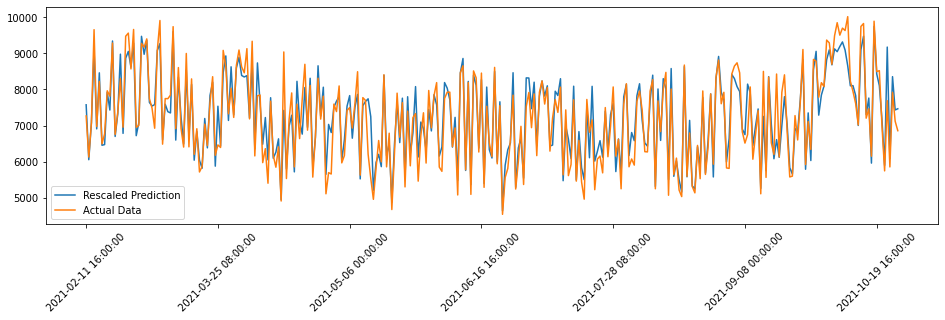

In [149]:
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return round(mape,2) # round to 2 decimals

# rescale values based on mean and std of 'Load' column
plot_actual_r = [ x*std+mean for x in plot_actual]
plot_pred_r = [ x*std+mean for x in plot_pred]

# calculate MAPE
# mape_value = mean_absolute_percentage_error(plot_actual, plot_pred)
mape_value = mape(plot_actual_r,plot_pred_r)

print(f"Mean Absolute Percentage Error (MAPE): {mape_value} %")

# Get dates for plotting (test_data)
datesx = list(df_backup[df_backup['year'] == 2021]['Date'])

# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(16,4))

# convert list of lists to list (np.hstack)
# get every N-th value of predicion and data list and display them in common plot
N = 1000
ax.plot(plot_pred_r[::N], label='Rescaled Prediction')
ax.plot(plot_actual_r[::N], label='Actual Data')
ax.set_xticklabels(datesx[::N], rotation=45)
ax.legend();

In [174]:
# The tensorboard logger is pretty nifty too!
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5032), started 3 days, 2:38:08 ago. (Use '!kill 5032' to kill it.)

In [ ]:
# # replace countries with a unique integer based on country_dict
# country_dict = {}
# for idx,country in enumerate(df['country'].unique()): country_dict[country] = idx
# df.replace({"country": country_dict}, inplace=True)

# # drop columns that do not contain numbers
# # (since dataframe is editted to have a freq of 1hour, minute/second column is useless)
# fields_to_drop = ['datetime', 'Date', 'timestamp', 'WN','minute','second']
# df.drop(fields_to_drop, axis=1, inplace = True, errors='ignore')

# #replace boolean true/false with 1/0
# df[['weekend','holiday']] = df[['weekend','holiday']].replace({True: 1, False: 0})

In [ ]:
class MyTimeSeriesDataset(Dataset):
    def __init__(self, df, lookback_window, forecast_horizon):
        self.l_window = lookback_window
        self.f_horizon = forecast_horizon
        
        # Reset "Unnamed: 0" based on shape of df it is in 
        df['Unnamed: 0'] = range(1, len(df) + 1)
        df_new = df.copy()    
        self.dataset = df_new

        for inc in range(0,int(lookback_window)):
            df_new['feauture_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
        df_new['Load'] = df_new['Load'].shift(-int(lookback_window))
        
        for inc in range(0,int(forecast_horizon)):
            df_new['target_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # drop lines that have NaN and reset indexing of csv file
        df_new = df_new.dropna().reset_index(drop=True)    
        
        # drop first two columns ('Unnamed: 0','Load') of dataframe
        df_new = df_new.iloc[: , 2:]        
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input = self.dataset.iloc[:,:self.l_window] 
        output = self.dataset.iloc[:,-self.f_horizon:]
        return input,output


lookback_window = 5
forecast_horizon = 3    
trainLoader = DataLoader(MyTimeSeriesDataset(train_data,lookback_window,forecast_horizon))
valLoader = DataLoader(MyTimeSeriesDataset(validation_data,lookback_window,forecast_horizon))
testLoader = DataLoader(MyTimeSeriesDataset(test_data,lookback_window,forecast_horizon))